In [1]:
%%capture --no-stderr
%pip install -U langchain_core langchain_community langchain-ollama

In [2]:
%%capture --no-stderr
%pip install langfuse langchain --upgrade

In [3]:
import os, getpass

def _set_env(var: str):
    os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")

LANGFUSE_PUBLIC_KEY:  ········
LANGFUSE_SECRET_KEY:  ········


In [4]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

# Initialize Langfuse client
langfuse = Langfuse(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)

langfuse_handler = CallbackHandler(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)


In [5]:
# Optional, verify that Langfuse is configured correctly
assert langfuse.auth_check()
assert langfuse_handler.auth_check()

#### Let's create a prompt programatically for event planning

In [6]:
langfuse.create_prompt(
    name="event-planner",
    prompt=
    "Plan an event titled {{event_name}}. The event will be about: {{event_description}}. "
    "The event will be held in {{location}} on {{date}}. "
    "Consider the following factors: audience, budget, venue, catering options, and entertainment. "
    "Provide a detailed plan including potential vendors and logistics.",
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["development"]
);

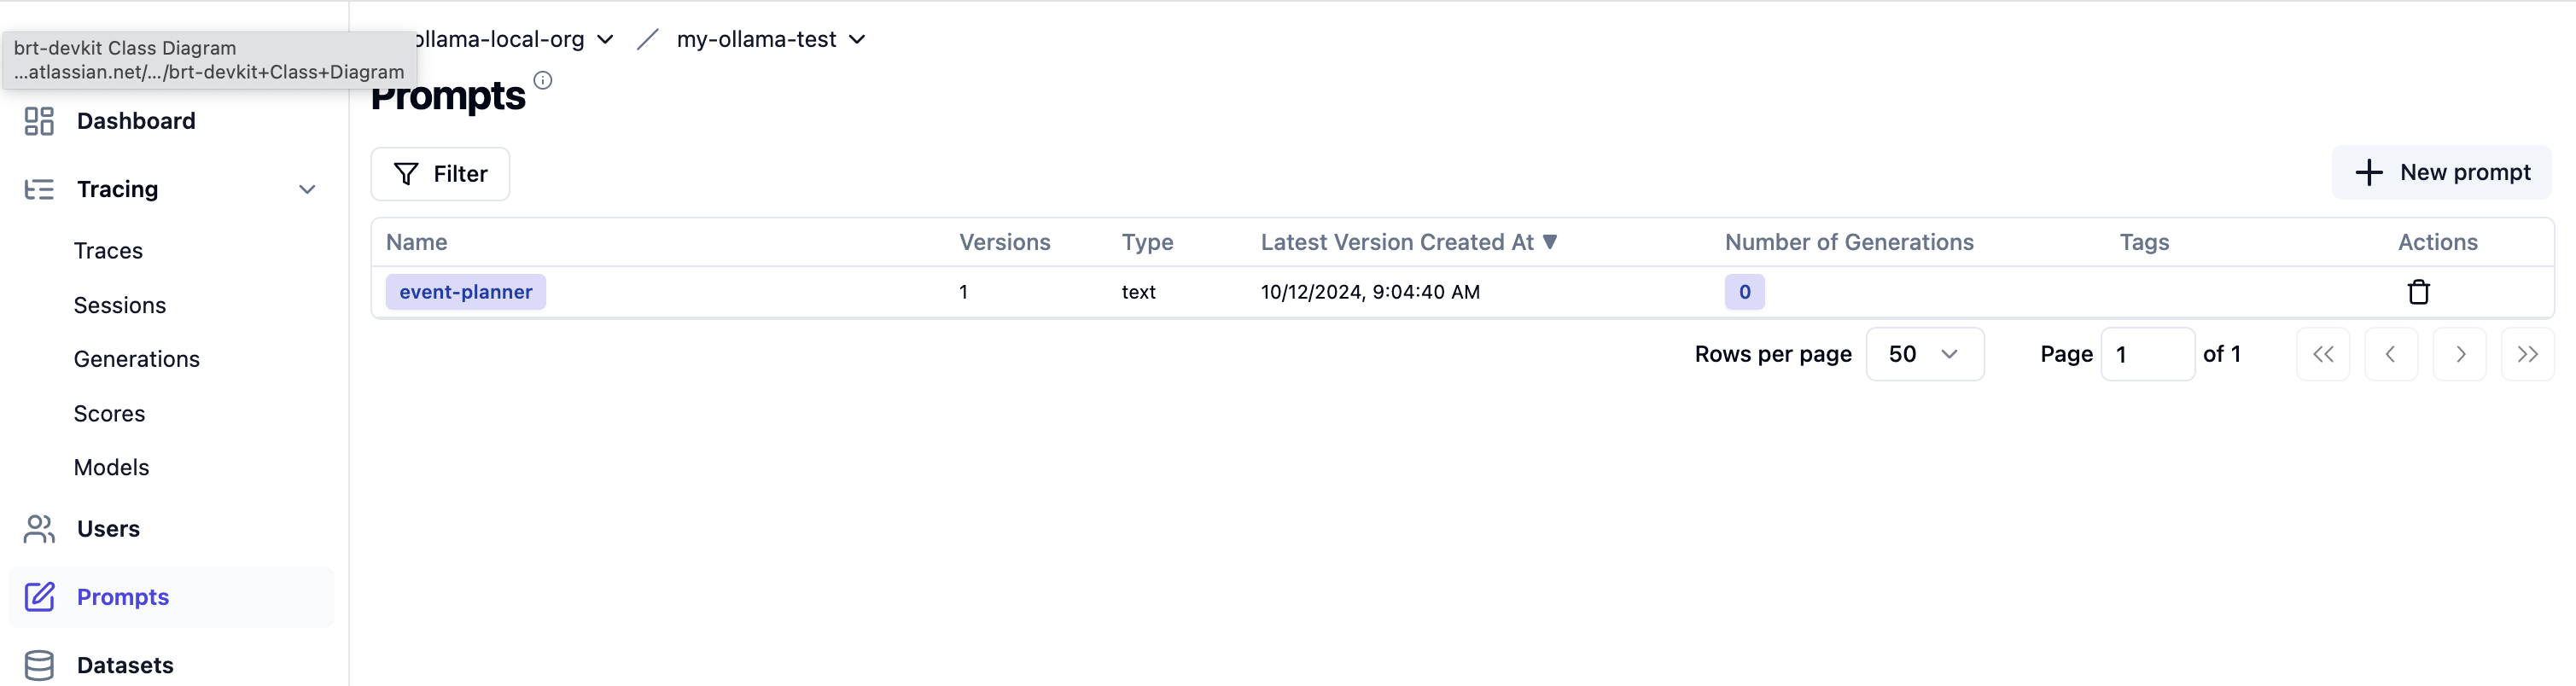

### Get current development version of prompt

In [7]:
langfuse_prompt = langfuse.get_prompt("event-planner", label=["development"])

In [8]:
langfuse_prompt.__dict__

{'name': 'event-planner',
 'version': 1,
 'config': {'model': 'llama3.1', 'temperature': 0},
 'labels': ['development', 'latest'],
 'tags': [],
 'is_fallback': False,
 'prompt': 'Plan an event titled {{event_name}}. The event will be about: {{event_description}}. The event will be held in {{location}} on {{date}}. Consider the following factors: audience, budget, venue, catering options, and entertainment. Provide a detailed plan including potential vendors and logistics.'}

In [9]:
print(langfuse_prompt.get_langchain_prompt())

Plan an event titled {event_name}. The event will be about: {event_description}. The event will be held in {location} on {date}. Consider the following factors: audience, budget, venue, catering options, and entertainment. Provide a detailed plan including potential vendors and logistics.


In [10]:
from langchain_core.prompts.prompt import PromptTemplate
 
langchain_prompt = PromptTemplate(
        #input_variables=["event_name", "event_description", "location", "date"], 
        template=langfuse_prompt.get_langchain_prompt(),
        metadata={"langfuse_prompt": langfuse_prompt},
)

In [11]:
model = langfuse_prompt.config["model"]
temperature = str(langfuse_prompt.config["temperature"])
print(f"Prompt model configurations\nModel: {model}\nTemperature: {temperature}")

Prompt model configurations
Model: llama3.1
Temperature: 0


In [12]:
from langchain_ollama import ChatOllama

ollama_model = ChatOllama(
    model=model,
    temperature=temperature
)
event_planner_chain = langchain_prompt | ollama_model

In [13]:
example_input = {
    "event_name": "Wedding",
    "event_description": "The wedding of Julia and Alex, a charming couple who share a love for art and nature. This special day will celebrate their journey together with a blend of traditional and contemporary elements, reflecting their unique personalities.",
    "location": "Central Park, New York City",
    "date": "June 5, 2024"
}

In [14]:
# we pass the callback handler to the chain to trace the run in Langfuse
response = event_planner_chain.invoke(input=example_input,config={"callbacks":[langfuse_handler]})
 
print(response.content)

**Wedding Event Plan: Julia and Alex's Special Day**

**Event Concept:** A whimsical and romantic celebration of love, art, and nature, blending traditional and contemporary elements to reflect the couple's unique personalities.

**Date:** June 5, 2024
**Time:** 3:00 pm - 10:00 pm (ceremony at 3:00 pm, cocktail hour at 4:30 pm, dinner at 6:00 pm)
**Location:** Central Park, New York City

**Audience:**

* Guests: 150 close friends and family members
* Age range: 25-60 years old
* Interests: Art, nature, music, food, and celebration of love

**Budget:** $75,000 (inclusive of all expenses)

**Venue:**

* **Central Park**: The picturesque park will serve as the backdrop for the ceremony, cocktail hour, and dinner. A private area within the park has been reserved for the event.
* **Tented Structure**: A custom-designed tent with a natural, earthy aesthetic will be set up to accommodate the ceremony, cocktail hour, and dinner.

**Catering Options:**

* **Food**: A seasonal, farm-to-table me

### Lets take a look at LangFuse

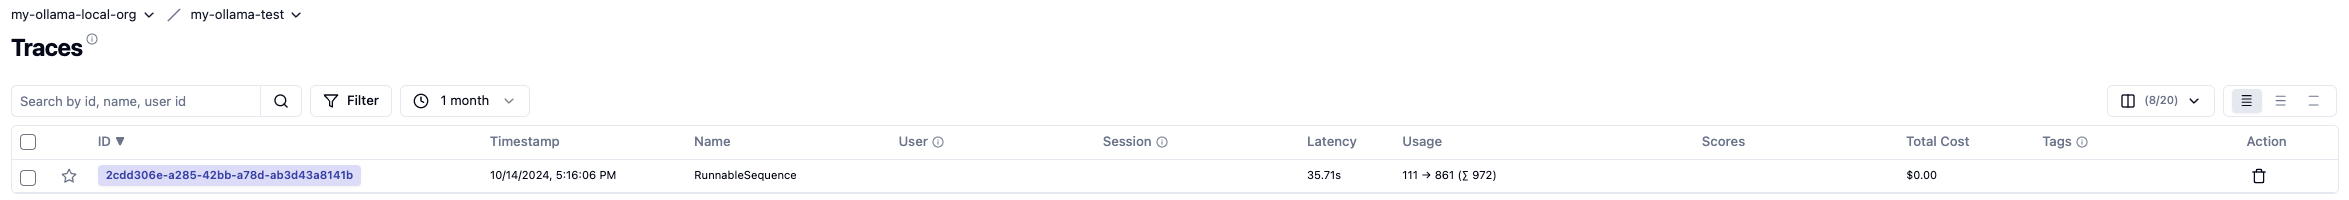

Here we can see the full Input and Output of each Trace phase, and following LangFuse documentation it means the following:

### Now inside the trace details

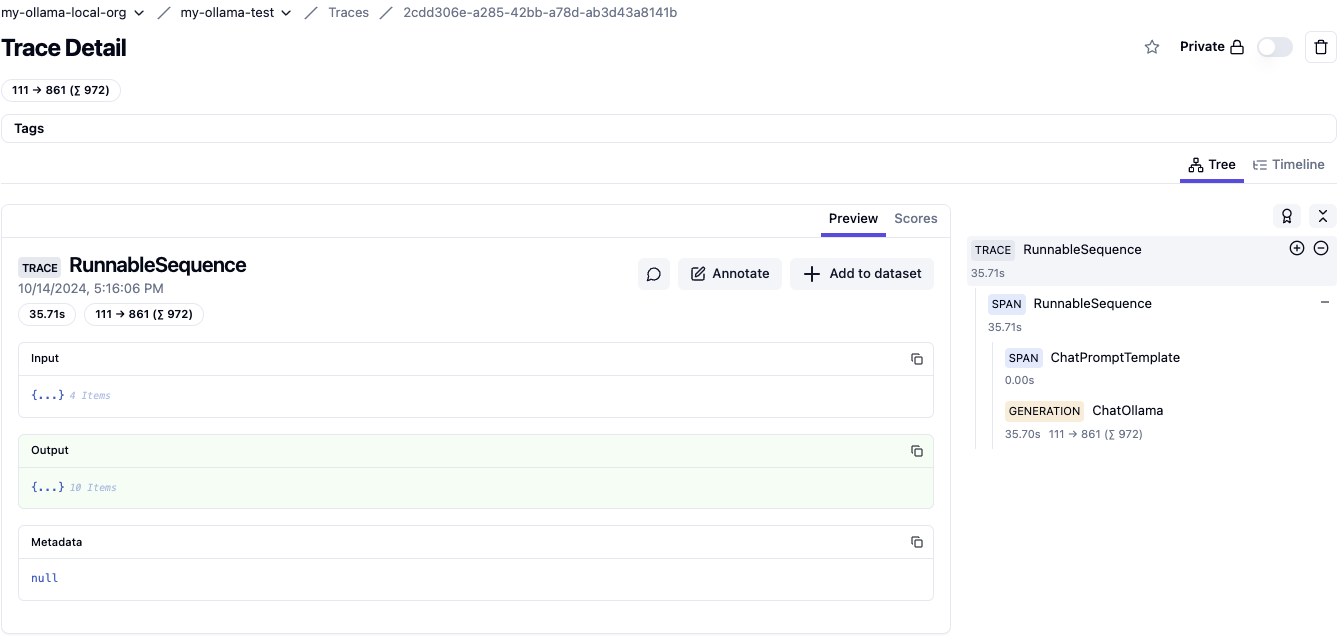

- Traces

A Trace represents a single execution of a LLM feature. It is a container for all succeeding objects.

- Observations

Each Trace can contain multiple Observations to record individual steps of an execution. There are different types of Observations:

1. Events are the basic building block. They are used to track discrete events in a Trace.
2. Spans track time periods and include an end_time.
3. Generations are a specific type of Spans which are used to record generations of an AI model. They contain additional metadata about the model, LLM token and cost tracking, and the prompt/completions are specifically rendered in the langfuse UI.

With that in mind, we have to take a look specifically to the **GENERATION** to check the LLM input and LLM output, because the Trace input can be something different like in our case the parameters of a prompt

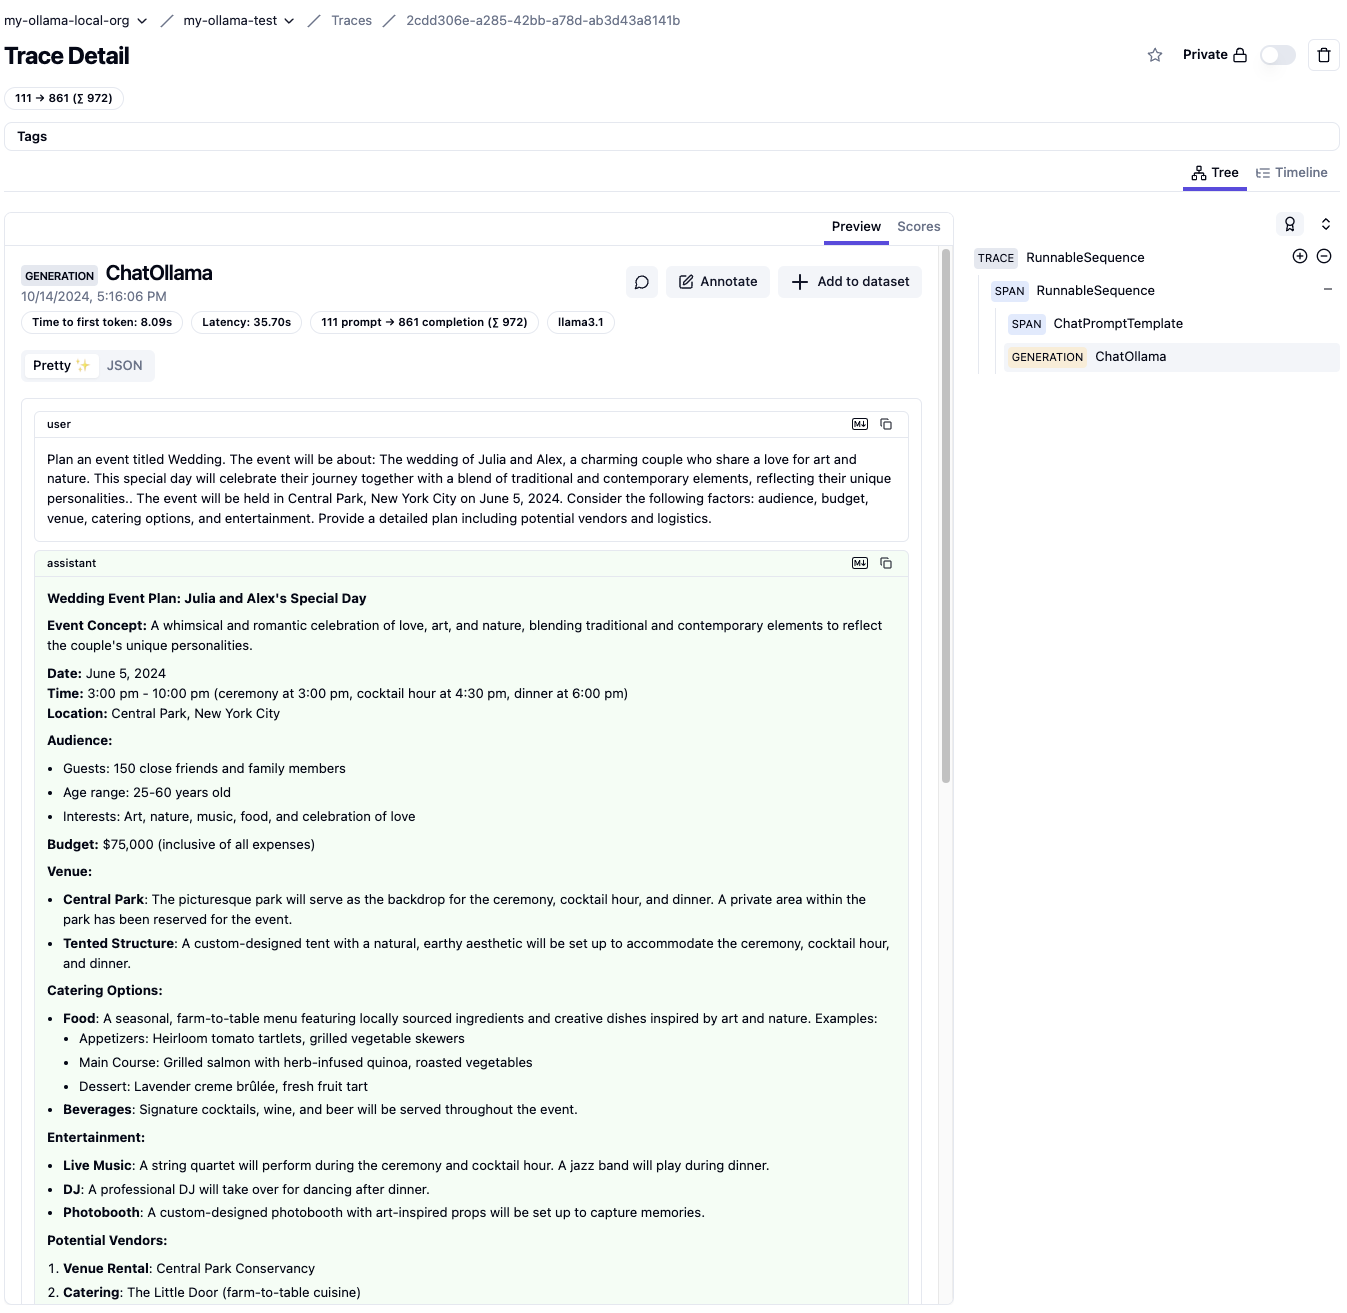


In [15]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Respond with CORRECT or INCORRECT:
    Grade:
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
);

In [30]:
eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label=["evaluation"])

In [67]:
eval_prompt = eval_prompt_from_langfuse.get_langchain_prompt()
eval_prompt = eval_prompt.replace("{{", "{").replace("}}", "}")

In [69]:
from langchain_core.prompts.prompt import PromptTemplate

EVAL_PROMPT = PromptTemplate(
    input_variables=["query", "answer", "result"], 
    template=eval_prompt,
    metadata={"langfuse_prompt": eval_prompt_from_langfuse}
)

# We should use an advanced LLM as evaluator, use this only for testing/learning purposes
eval_llama = ChatOllama(
    model=model,
    temperature=temperature
)

eval_chain = EVAL_PROMPT | eval_llama

In [118]:
traces = langfuse.fetch_traces()

In [170]:
last_trace = traces.data[16] # Last trace

In [176]:
last_trace_input = last_trace.input
last_trace_result = last_trace.output["content"]

In [177]:
last_trace_result

'**Event Name:** "Summer Solstice Soiree"\n\n**Event Description:** A vibrant celebration of music, art, and community, featuring live performances, interactive installations, and delicious food and drinks, all set against the stunning backdrop of Central Park on the longest day of the year.\n\n**Target Audience:**\n\n* Demographics: Young professionals (25-45), families with children, and art enthusiasts\n* Psychographics: People who value creativity, community, and self-expression\n\n**Budget:** $250,000\n\n**Venue:**\n\n* Location: Central Park, New York City (specifically, the Great Lawn near the Loeb Boathouse)\n* Date: June 5, 2024 (Summer Solstice)\n* Time: 3 pm - 9 pm\n* Capacity: 2,500 attendees\n\n**Catering Options:**\n\n* Food:\n\t+ Local food vendors offering a variety of cuisines (e.g., tacos, BBQ, Italian)\n\t+ Specialty food stations (e.g., ice cream, popcorn, cotton candy)\n* Beverages:\n\t+ Signature cocktails featuring seasonal ingredients\n\t+ Craft beer and wine op

In [80]:
def trace_score(query, result):
    response = eval_chain.invoke(
        {
            "query": query,
            "answer": """Event Title: The Wedding of Julia and Alex

                        Event Date: June 5, 2024
                        
                        Venue: Central Park, New York City
                        
                        Event Description: The wedding of Julia and Alex will be a beautiful celebration of their love, combining their passion for art and nature. This event will blend traditional and contemporary elements to reflect the unique personalities of the couple. Set in the picturesque Central Park, the wedding will offer a serene and romantic backdrop, perfect for such a joyous occasion.
                        
                        Audience: The expected audience will include family members, close friends, and colleagues of Julia and Alex, totaling around 150 guests. The guest list will comprise people who appreciate art and nature, and who have been significant in the couple’s journey.
                        
                        Budget: The total budget for the wedding is estimated to be around $50,000. This will cover venue, catering, entertainment, decorations, photography, and other miscellaneous expenses.
                        
                        Venue Details: The ceremony will take place at the Central Park Conservatory Garden, which offers a stunning and private space with lush greenery and beautiful floral arrangements. The reception will follow at the nearby Loeb Boathouse, which provides an elegant setting by the lake.
                        
                        Catering Options:
                        
                        Great Performances: Known for their focus on sustainable and locally sourced ingredients, they will provide a customized menu that includes vegetarian and vegan options, reflecting the couple’s dietary preferences.
                        Union Square Events: Offering a farm-to-table experience, they will create a menu that highlights seasonal ingredients, complementing the natural setting of Central Park.
                        Entertainment:
                        
                        Live Band: A local jazz band will perform during the reception, providing a lively and sophisticated atmosphere.
                        DJ: Post-live band, a DJ will take over to play a mix of contemporary hits and classic favorites, ensuring the dance floor stays energetic.
                        Art Installations: Interactive art installations by local artists will be set up around the reception area, allowing guests to engage with and appreciate art in various forms.
                        Decorations:
                        
                        Floral Arrangements: Emphasizing greenery and wildflowers, the floral decorations will be handled by a local florist specializing in organic and natural designs.
                        Lighting: Soft, ambient lighting will be arranged to complement the natural sunset, with fairy lights and lanterns enhancing the romantic setting.
                        Photography:
                        
                        Alex Knight Photography: Specializing in natural light photography, they will capture the essence of the day, focusing on candid moments and breathtaking landscapes.
                        Logistics:
                        
                        Permits: Necessary permits for hosting the event in Central Park will be secured well in advance.
                        Transportation: Shuttle services will be arranged for guests from designated parking areas to the venue.
                        Accommodations: A block of rooms will be reserved at a nearby hotel for out-of-town guests, ensuring convenience and comfort.
                        Weather Contingency: In case of inclement weather, tents and canopies will be set up to protect guests and ensure the event proceeds smoothly.
                        Timeline:
                        
                        4:00 PM: Ceremony at Central Park Conservatory Garden
                        5:00 PM: Cocktail hour with light refreshments and interactive art installations
                        6:00 PM: Reception at Loeb Boathouse, dinner served
                        7:30 PM: Speeches and toasts
                        8:00 PM: First dance followed by live band performance
                        10:00 PM: DJ takes over
                        12:00 AM: Event concludes""",
            # These results are gathered from GPT4, this is wrong, this should be manually setup
            "result": result
        },
        config={"callbacks":[langfuse_handler]}
    )
    return response.content

trace_score(query=last_trace_input, result=last_trace_result)

In [82]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.
    
    If the two answers are different, then the score should be 0.
    Please you your score in a 'score' XML tag, and any reasoning
    in a 'reason' XML tag.
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

### How the new version should looks like:

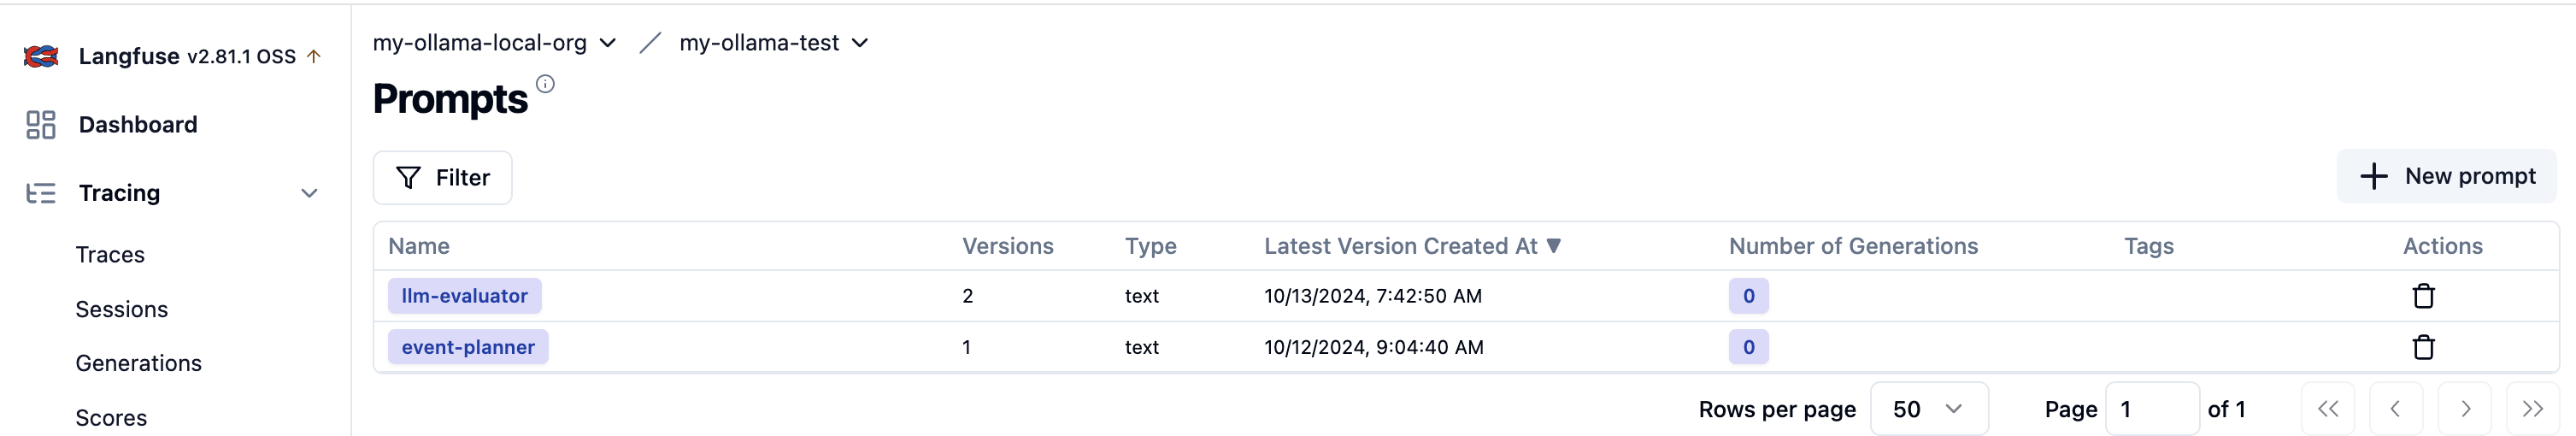

In [186]:
# These results are gathered from GPT4, this is wrong, this should be manually setup
real_answer = """
Event Title: The Wedding of Julia and Alex

Event Date: June 5, 2024

Venue: Central Park, New York City

Event Description: The wedding of Julia and Alex will be a beautiful celebration of their love, combining their passion for art and nature. This event will blend traditional and contemporary elements to reflect the unique personalities of the couple. Set in the picturesque Central Park, the wedding will offer a serene and romantic backdrop, perfect for such a joyous occasion.

Audience: The expected audience will include family members, close friends, and colleagues of Julia and Alex, totaling around 150 guests. The guest list will comprise people who appreciate art and nature, and who have been significant in the couple’s journey.

Budget: The total budget for the wedding is estimated to be around $50,000. This will cover venue, catering, entertainment, decorations, photography, and other miscellaneous expenses.

Venue Details: The ceremony will take place at the Central Park Conservatory Garden, which offers a stunning and private space with lush greenery and beautiful floral arrangements. The reception will follow at the nearby Loeb Boathouse, which provides an elegant setting by the lake.

Catering Options:

Great Performances: Known for their focus on sustainable and locally sourced ingredients, they will provide a customized menu that includes vegetarian and vegan options, reflecting the couple’s dietary preferences.
Union Square Events: Offering a farm-to-table experience, they will create a menu that highlights seasonal ingredients, complementing the natural setting of Central Park.
Entertainment:

Live Band: A local jazz band will perform during the reception, providing a lively and sophisticated atmosphere.
DJ: Post-live band, a DJ will take over to play a mix of contemporary hits and classic favorites, ensuring the dance floor stays energetic.
Art Installations: Interactive art installations by local artists will be set up around the reception area, allowing guests to engage with and appreciate art in various forms.
Decorations:

Floral Arrangements: Emphasizing greenery and wildflowers, the floral decorations will be handled by a local florist specializing in organic and natural designs.
Lighting: Soft, ambient lighting will be arranged to complement the natural sunset, with fairy lights and lanterns enhancing the romantic setting.
Photography:

Alex Knight Photography: Specializing in natural light photography, they will capture the essence of the day, focusing on candid moments and breathtaking landscapes.
Logistics:
                        
Permits: Necessary permits for hosting the event in Central Park will be secured well in advance.
Transportation: Shuttle services will be arranged for guests from designated parking areas to the venue.
Accommodations: A block of rooms will be reserved at a nearby hotel for out-of-town guests, ensuring convenience and comfort.
Weather Contingency: In case of inclement weather, tents and canopies will be set up to protect guests and ensure the event proceeds smoothly.
Timeline:

4:00 PM: Ceremony at Central Park Conservatory Garden
5:00 PM: Cocktail hour with light refreshments and interactive art installations
6:00 PM: Reception at Loeb Boathouse, dinner served
7:30 PM: Speeches and toasts
8:00 PM: First dance followed by live band performance
10:00 PM: DJ takes over
12:00 AM: Event concludes
"""


def trace_score(input_for_initial_prompt, result):

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label=["development"])
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label=["evaluation"])

    # Insert variables into prompt template
    compiled_prompt = eval_prompt_from_langfuse.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        metadata={"langfuse_prompt": eval_prompt_from_langfuse}
    )
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )
    return response.content

In [187]:
response_in_xml_format = trace_score(input_for_initial_prompt=last_trace_input, result=last_trace_result)

In [188]:
response_in_xml_format

'<score>50</score>\n\n<reason>\nThe student\'s answer is partially correct. They have provided a detailed plan for an event titled "Summer Solstice Soiree", which includes information on target audience, budget, venue, catering options, entertainment, and logistics.\n\nHowever, there are several key differences between the student\'s answer and the correct answer:\n\n* The event title and description do not match the original question, which was to plan a wedding for Julia and Alex.\n* The budget is significantly higher than the original $50,000 budget.\n* The venue and date are different from the original Central Park location on June 5, 2024.\n* The catering options and entertainment lineup are more extensive and elaborate than what was originally planned.\n\nWhile the student\'s answer shows some creativity and attention to detail, it does not accurately address the original question. Therefore, a score of 50 is warranted.</reason>'

In [189]:
import xml.etree.ElementTree as ET
tree = ET.ElementTree(ET.fromstring(response_in_xml_format))

ParseError: junk after document element: line 3, column 0 (<string>)

### We will need in some way force a formatted output response 

In [183]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, model_validator

In [218]:
# Define your desired data structure.
class ScoreResult(BaseModel):
    score: float = Field(description="numerical score for the evaluated prompt")
    reason: str = Field(description="explanation of the designed score")

In [219]:
# Set up a parser + inject instructions into the prompt template.
pydantic_parser = PydanticOutputParser(pydantic_object=ScoreResult)

In [190]:
def trace_score_with_output_format(input_for_initial_prompt, result, parser):

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label=["development"])
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label=["evaluation"])

    # Insert variables into prompt template
    compiled_prompt = eval_prompt_from_langfuse.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        metadata={"langfuse_prompt": eval_prompt_from_langfuse},
        partial_variables={"format_instructions": parser.get_format_instructions()} # (NEW) inject instructions into the prompt template.
    )
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )
    response = parser.invoke(response)
    return response.content

In [191]:
trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

OutputParserException: Invalid json output: <score>50</score>

<reason>
The student's answer is partially correct. They have provided a detailed plan for an event titled "Summer Solstice Soiree", which includes information on target audience, budget, venue, catering options, entertainment, and logistics.

However, there are several key differences between the student's answer and the correct answer:

* The event title and description do not match the original question, which was to plan a wedding for Julia and Alex.
* The budget is significantly higher than the original $50,000 budget.
* The venue and date are different from the original Central Park location on June 5, 2024.
* The catering options and entertainment lineup are more extensive and elaborate than what was originally planned.

While the student's answer shows some creativity and attention to detail, it does not accurately address the original question. Therefore, a score of 50 is warranted.</reason>

**As we can see it looks the previous prompt has harcoded some output format instructions that might be introducing some noise, lets erase that part**

In [193]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

In [ ]:
def trace_score_with_output_format(input_for_initial_prompt, result, parser):

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label=["development"])
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt = langfuse.get_prompt("llm-evaluator", label=["evaluation"])

    # Insert variables into prompt template
    compiled_prompt = eval_prompt.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        partial_variables={"format_instructions": parser.get_format_instructions()} # (NEW) inject instructions into the prompt template.
    )

    #print("prompt: ", EVAL_PROMPT)
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )

    print("response before invoke: ", response.content) 
    response = parser.invoke(response)

    
    return response.content

In [200]:
trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

prompt:  input_variables=[] input_types={} partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"description": "numerical score for the evaluated prompt", "title": "Score", "type": "string"}, "result": {"description": "explanation of the designed score", "title": "Result", "type": "string"}}, "required": ["score", "result"]}\n```'} template='You are an expert professor specialized in grading students\' answers to questions.\n    You are grading the following question:\n    Plan an event titled Wedding. The event will be 

OutputParserException: Invalid json output: I'll carefully compare the predicted answer with the real answer to determine the score.

**Event Name:** "Summer Solstice Soiree" (vs) **Event Title: The Wedding of Julia and Alex**

The predicted answer has a more creative event name, while the real answer is straightforward. Score: 80% (the predicted answer is not relevant to the actual question)

**Event Description:** A vibrant celebration... (vs) **Event Description:** The wedding of Julia and Alex will be a beautiful celebration...

The predicted answer focuses on a general theme, whereas the real answer specifically describes the couple's love story. Score: 60% (the predicted answer is not relevant to the actual question)

**Target Audience:** Young professionals, families with children, art enthusiasts (vs) **Audience:** The expected audience will include family members, close friends, and colleagues...

The predicted answer has a broader target audience, while the real answer focuses on people who are significant in the couple's journey. Score: 70% (the predicted answer is somewhat relevant)

**Budget:** $250,000 (vs) **Budget:** The total budget for the wedding is estimated to be around $50,000.

The predicted answer has a significantly higher budget than the real answer. Score: 0% (this is a major discrepancy)

**Venue:** Central Park, Great Lawn near Loeb Boathouse (vs) **Venue Details:** The ceremony will take place at the Central Park Conservatory Garden...

The predicted answer chooses a different venue within Central Park, while the real answer specifies a more intimate and private space. Score: 50% (the predicted answer is somewhat relevant)

**Catering Options:** Local food vendors, specialty food stations, signature cocktails... (vs) **Catering Options:** Great Performances, Union Square Events...

The predicted answer has a broader range of catering options, while the real answer focuses on two specific vendors. Score: 60% (the predicted answer is somewhat relevant)

**Entertainment:** Live music, interactive installations, activities... (vs) **Entertainment:** Live Music, Interactive Installations...

The predicted answer has more diverse entertainment options, while the real answer focuses on live music and interactive installations. Score: 70% (the predicted answer is somewhat relevant)

**Potential Vendors:** Various vendors for food, beverage, entertainment, logistics... (vs) **Potential Vendors:** Not specified in the real answer.

The predicted answer lists various potential vendors, while the real answer does not provide this information. Score: 80% (this is a minor discrepancy)

**Logistics:** Security, waste management, accessibility... (vs) **Logistics:** Not specified in the real answer.

The predicted answer addresses logistics and production, while the real answer does not provide this information. Score: 70% (this is a minor discrepancy)

**Timeline:** A detailed timeline for the event planning process... (vs) **Timeline:** Not specified in the real answer.

The predicted answer provides a detailed timeline, while the real answer does not provide this information. Score: 80% (this is a minor discrepancy)

**Budget Breakdown:** A breakdown of the estimated costs for the event... (vs) **Budget Breakdown:** Not specified in the real answer.

The predicted answer provides a budget breakdown, while the real answer does not provide this information. Score: 70% (this is a minor discrepancy)

Overall score: 55%

This student answer demonstrates some understanding of the event planning process but has significant discrepancies with the correct answer. The score reflects these differences.

In [ ]:
### THe prompt is not printing the reason and score as json keys, lets iterate through the prompt

In [210]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.

    Output your response in the demanded json format, additionally it must contain 2 keys 'score' and 'reason'
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

In [223]:
def trace_score_with_output_format(input_for_initial_prompt, result, parser) -> ScoreResult:

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label=["development"])
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt = langfuse.get_prompt("llm-evaluator", label=["evaluation"])

    # Insert variables into prompt template
    compiled_prompt = eval_prompt.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        partial_variables={"format_instructions": parser.get_format_instructions()} # (NEW) inject instructions into the prompt template.
    )

    #print("prompt: ", EVAL_PROMPT)
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )

    response = parser.invoke(response)

    
    return response

In [224]:
trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

ScoreResult(score=60.0, reason="The predicted answer is mostly correct but lacks specific details about Julia and Alex's love for art and nature. The budget is also significantly higher than the actual budget, and some of the vendors mentioned are not relevant to a wedding event.")

In [225]:
score_result_object = trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

In [227]:
last_trace.id

'39fa3a63-498c-4002-9818-bca2a392f857'

In [229]:
langfuse.score(
    trace_id=last_trace.id,
    name="LLMBasedScore",
    value=score_result_object.score,
    comment=score_result_object.reason
)